In [8]:
import os
import glob
import datetime

# Define the directory to search for text files
directory = '/Users/Feifei/Box/BR_remote_sensing/FastRivers/AmuDarya_Kerki/rivgraph'  # Replace with your desired directory path

# Initialize lists for data and datetime values
datetimes = []
data = []

# Iterate over each directory and its subdirectories
for root, dirs, files in os.walk(directory):
    # Find all text files starting with "output_eBI" in the current directory
    file_paths = glob.glob(os.path.join(root, "output_eBI*.txt"))

    # Sort the file paths alphabetically
    file_paths.sort()

    # Iterate over each file path
    for file_path in file_paths:
        # Read the text file into an array, skipping the first line
        arr = np.loadtxt(file_path, skiprows=1)
        data.append(arr)

        # Read the first line of the file as a datetime value
        with open(file_path, 'r') as file:
            first_line = file.readline().strip()  # Read the first line

            if first_line.startswith('Date:'):
                datetime_str = first_line.split(": ")[1]  # Extract the datetime string
                #datetime_value = datetime.datetime.strptime(datetime_str, '%B %Y').strftime('%b %Y')  # Convert to month and year string
                datetime_value = datetime.datetime.strptime(datetime_str, '%B %Y').strftime('%Y')  # Convert to month and year string
                datetimes.append(datetime_value)

# Convert the lists to arrays
data_combined = np.array(data)
datetimes_combined = np.array(datetimes)

# Reshape the data to have shape (18, 1)
data_reshaped = data_combined.reshape(30, 1)
datetimes_combined = datetimes_combined.reshape(30, 1)


C:\Users\Feifei\AppData\Local\Temp\ipykernel_17864\230689507.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_combined = np.array(data)


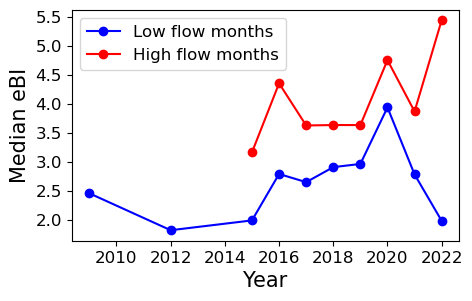

In [82]:
import matplotlib.pyplot as plt

# Convert the "datetimes_combined" array to string type
datetimes_combined = datetimes_combined.astype(str)

# Create a boolean mask for values starting with "Oct" or "Sep"
low_flow = np.logical_or(np.char.startswith(datetimes_combined, "Oct"), np.char.startswith(datetimes_combined, "Sep"))

# Separate the values based on the mask
data_low_flow = data_reshaped[low_flow]
data_high_flow = data_reshaped[~low_flow]

low_medians = np.empty(data_low_flow.shape[0])
high_medians = np.empty(data_high_flow.shape[0])

# Create new arrays with corresponding datetime values
low_flow_datetimes = datetimes_combined[low_flow]
high_flow_datetimes = datetimes_combined[~low_flow]

# Extract only the year from datetime values
low_flow_years = [datetime.datetime.strptime(dt, "%b %Y").year for dt in low_flow_datetimes]
high_flow_years = [datetime.datetime.strptime(dt, "%b %Y").year for dt in high_flow_datetimes]


# Iterate over the arrays in data_low_flow and calculate the medians
for i, array in enumerate(data_low_flow):
    low_medians[i] = np.median(array)

for i, array in enumerate(data_high_flow):
    high_medians[i] = np.median(array)   

# Change the figure size
plt.figure(figsize=(5, 3))  # Set the desired width and height of the figure

# Plotting as points
plt.plot(low_flow_years, low_medians, marker="o", color="blue", label="Low flow months")  # Plot lines
plt.plot(high_flow_years, high_medians, marker="o", color="red", label="High flow months")  # Plot lines

# Customize the plot
plt.xlabel('Year', fontsize=15)
plt.ylabel('Median eBI', fontsize=15)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.show()


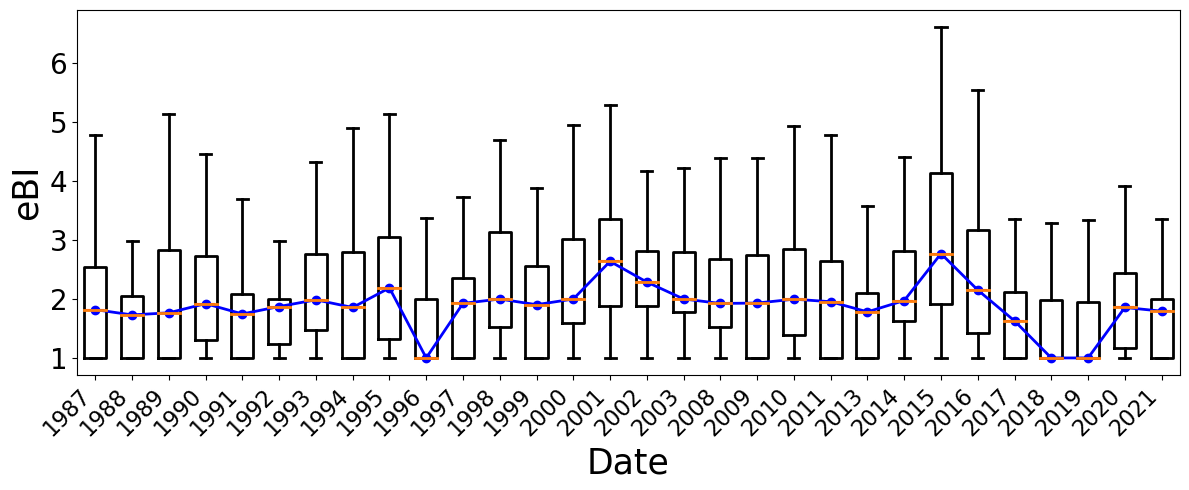

<Figure size 640x480 with 0 Axes>

In [14]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting the boxplots
fig, ax = plt.subplots(figsize=(12, 5))  # Adjust the figure size as needed

medians = []  # Store the median values
positions = np.arange(1, len(datetimes_combined) + 1)
for i, data_row in enumerate(data_reshaped):
    boxplot = ax.boxplot(data_row, positions=[i + 1], widths=0.6, labels=[datetimes_combined[i]],showfliers=False)

    # Set the linewidth for each component of the boxplot
    for component in boxplot.keys():
        plt.setp(boxplot[component], linewidth=2)  # Set the linewidth to 2

    # Get the median values
    median = boxplot["medians"][0].get_ydata()[0]
    medians.append(median)

    # Add a line through the median
    ax.hlines(median, i + 0.75, i + 1.25, color='red')

# Draw a line connecting medians
ax.plot(positions, medians, color='blue', marker='o', linestyle='-', linewidth=2)


# Adding labels and title
plt.xlabel('Date', fontsize=25)
plt.ylabel('eBI', fontsize=25)

# Customizing x-axis tick labels
xtick_labels = [date.split() for date in datetimes_combined.flatten()]  # Split the dates into two lines
xtick_labels = ['\n'.join(date) for date in xtick_labels]  # Join the split lines with a line break
plt.xticks(positions, xtick_labels, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=20)
# Display the plot
plt.tight_layout()  # Adjust the spacing between plot elements
plt.show()
plt.savefig('/Users/Feifei/Box/PlanetClassification/Tuotuo/eBI.png')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the Excel file
file_path = '/Users/Feifei/Box/PlanetClassification/Lietal_2021_data.xlsx'  # Replace with the path to your Excel file
sheet_name = 'Fig.4'
dataframe = pd.read_excel(file_path, sheet_name=sheet_name)


# Extract the "Year" and "Runoff (Q)" columns
year_column = dataframe['Year'].values[3:].astype(int)
runoff_column = dataframe['Runoff (Q)'].values[3:].astype(float)
sed_column = dataframe['Suspended sediment flux (SSF)'].values[3:].astype(float)

# Create a figure with a larger width
plt.figure(figsize=(15, 3))  # Adjust the width (first value) as needed

# Create the first subplot for the "Runoff" column
ax1 = plt.subplot(1, 1, 1)
ax1.plot(year_column, runoff_column, marker='o', color='blue',linewidth=2)
ax1.set_xlabel('Year',fontsize=20)
ax1.set_ylabel('Q (km3/yr)',fontsize=20)

# Set xtick positions and labels
#xtick_positions = [year for year in year_column if year % 2 == 1]  # Example: xticks for even years
xtick_labels = [str(year) for year in xtick_positions]
plt.xticks(xtick_positions, xtick_labels,fontsize=15)
plt.yticks(fontsize=15) 

# Create the second subplot for the "Suspended sediment flux (SSF)" column
ax2 = ax1.twinx()
ax2.plot(year_column, sed_column, marker='o', color='red',linewidth=2)
ax2.set_ylabel('SSF (Mt/yr)',fontsize=20)
plt.yticks(fontsize=15) 
# Customize the plot
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, ['Runoff (Q)', 'Suspended sediment flux (SSF)'], loc='upper left',fontsize=15)


# Add a vertical marker at x=2009
plt.axvline(x=2009, color='orange', linestyle='--')


# Show the plot
plt.show()

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the Excel file
file_path = '/Users/Feifei/Box/PlanetClassification/Lietal_HMA.xlsx'  # Replace with the path to your Excel file
sheet_name = 'Fig.2'
dataframe = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract the desired columns
desired_columns = ['Year', 'Q percentage anomaly (%)', 'Qs percentage anomaly (%)', 'Temperature anomaly (℃)']
extracted_data = dataframe[desired_columns]

# Set figure size
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot the Q percentage anomaly
ax1.plot(extracted_data['Year'], extracted_data['Q percentage anomaly (%)'], color='blue',label='Runoff (Q)')
ax1.plot(extracted_data['Year'], extracted_data['Qs percentage anomaly (%)'], color='orange',label='Sediment flux (Qs))')
ax1.set_xlabel('Year',fontsize=15)
ax1.set_ylabel('Percentage Anomaly', fontsize=15)
plt.yticks(fontsize=15) 
plt.xticks(fontsize=15) 


# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(extracted_data['Year'], extracted_data['Temperature anomaly (℃)'], color='red', label='Temperature (℃)')
plt.yticks(fontsize=15) 
ax2.set_ylabel('Temperature Anomaly (℃)',fontsize=15)

# Combine the legends and move it to the left
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize='large')

# Display the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Feifei/Box/PlanetClassification/Lietal_HMA.xlsx'

In [ ]:
# plot monthly discharge data

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv("/Users/Feifei/Box/PlanetClassification/Tuotuo/Q_monthly.csv")

# Extract the desired columns
precipitation = data["Precipitation (mm)"]
discharge = data["Discharge (m^3/s)"]

# Define the x-axis labels
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot the precipitation as a line plot
ax1.plot(months, precipitation, marker="o", color="blue", label="Precipitation (mm)")
ax1.set_xlabel("Month", fontsize=20)
ax1.set_ylabel("Precipitation (mm)", color="blue",fontsize=20)
ax1.tick_params(axis="y", labelcolor="blue",labelsize=20)

ax1.tick_params(axis="x", labelsize=17)

# Create a second y-axis for discharge as a bar plot
ax2 = ax1.twinx()
ax2.bar(months, discharge, color="red", alpha=0.5, label="Discharge (m$^3$/s)")
ax2.set_ylabel("Discharge (m$^3$/s)", color="red",fontsize=20)
ax2.tick_params(axis="y", labelcolor="red",labelsize=20)

# Display the legends
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels,fontsize=15)

# Show the plot
plt.show()

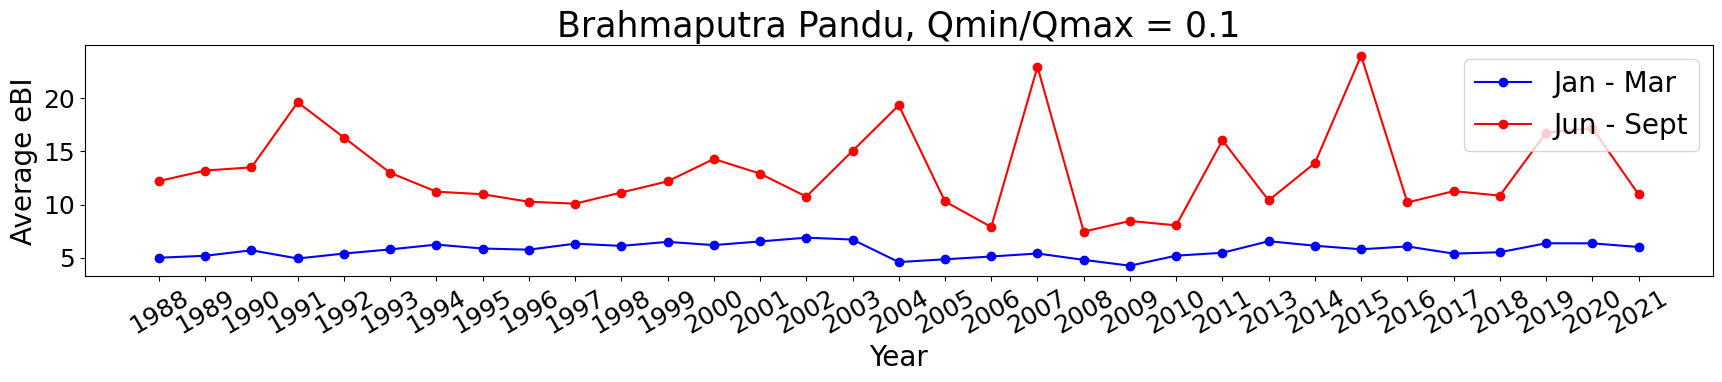

In [173]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\GEE_watermasks-master\ebi\Brahmaputra_Pandu\rivgraph\eBI_results.csv"

# Load CSV into a Pandas DataFrame with a header
df = pd.read_csv(csv_filepath, header=None)

# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '01' else 'Jun'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', label='January', linestyle='-')

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['06'], marker='o', color='red', label='Non-January', linestyle='-')



plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Brahmaputra Pandu, Qmin/Qmax = 0.1', fontsize=25)
plt.xticks(rotation=30, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Mar', 'Jun - Sept'], loc='upper right', fontsize=20)
# Show the plot
plt.show()


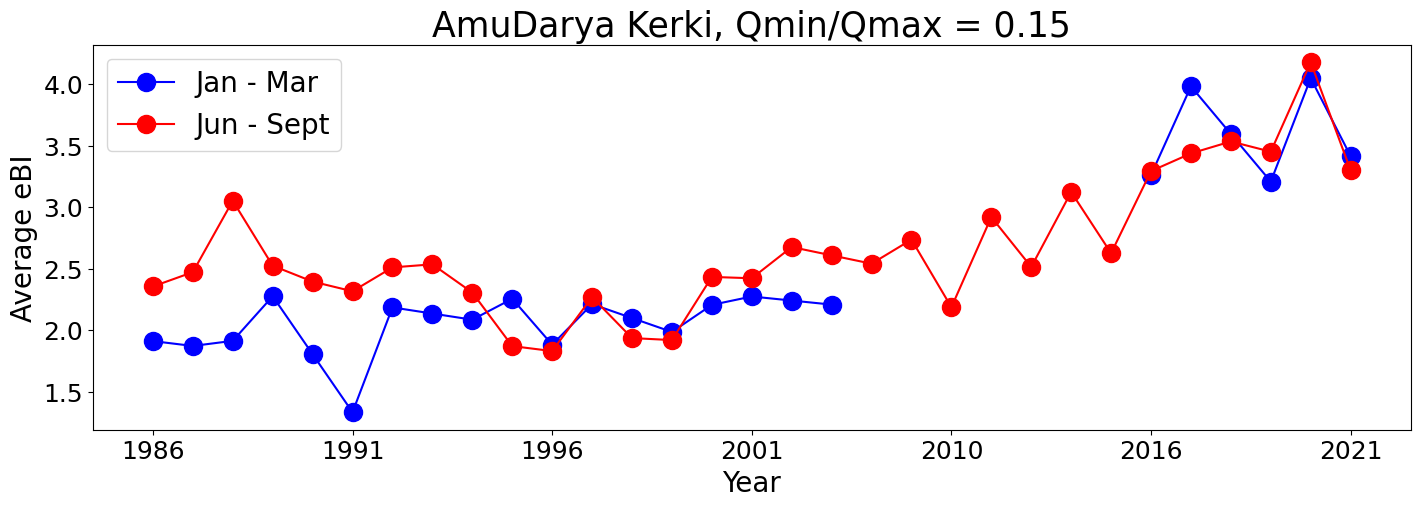

In [184]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"c:\Users\Feifei\GEE_watermasks-master\ebi\AmuDarya_Kerki\rivgraph\eBI_results.csv"

# Load CSV into a Pandas DataFrame with a header
df = pd.read_csv(csv_filepath, header=None)

# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '01' else 'Jun'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)
df_grouped.loc['2008':'2015', '01'] = float('nan')

# Set the figure size before plotting
plt.figure(figsize=(17, 5))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', label='January', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['06'], marker='o', color='red', label='Non-January', linestyle='-', markersize=13)



plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('AmuDarya Kerki, Qmin/Qmax = 0.15', fontsize=25)
plt.xticks(df_grouped.index[::5], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Mar', 'Jun - Sept'], loc='upper left', fontsize=20)
# Show the plot
plt.show()

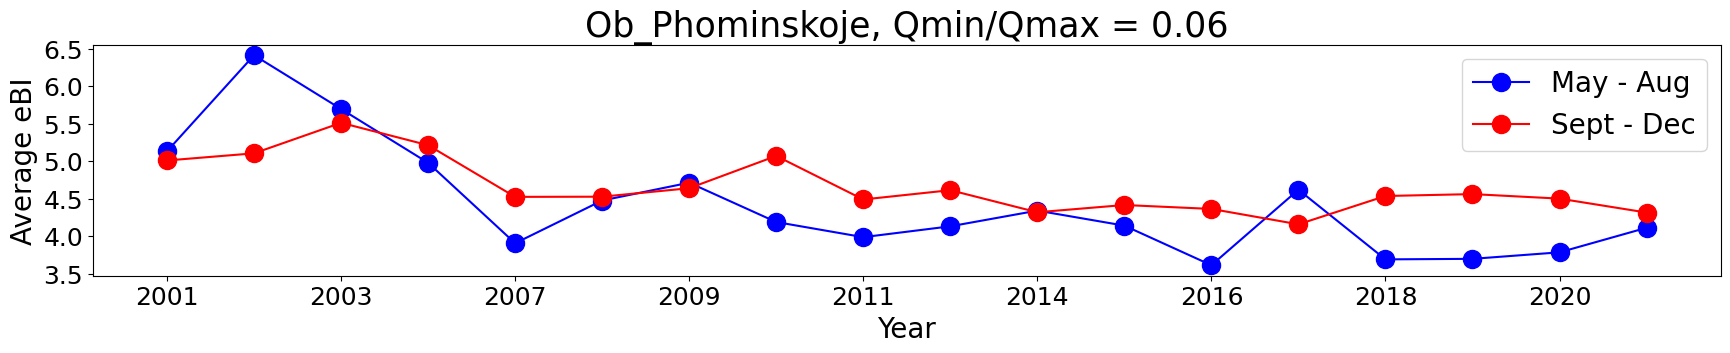

In [186]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\GEE_watermasks-master\ebi\Ob_Phominskoje\rivgraph\eBI_results.csv"

# Load CSV into a Pandas DataFrame with a header
df = pd.read_csv(csv_filepath, header=None)

# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year from the first column (file names)
df['year'] = df[0].apply(lambda x: ''.join(char for char in str(x) if char.isdigit())[:4] if isinstance(x, str) else '')

df['month'] = df[0].apply(lambda x: str(x).split('_')[3][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '12' else 'Jun'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['12'], marker='o', color='blue', label='January', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['09'], marker='o', color='red', label='Non-January', linestyle='-', markersize=13)



plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Ob_Phominskoje, Qmin/Qmax = 0.06', fontsize=25)
plt.xticks(df_grouped.index[::2], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['May - Aug', 'Sept - Dec'], loc='upper right', fontsize=20)
# Show the plot
plt.show()

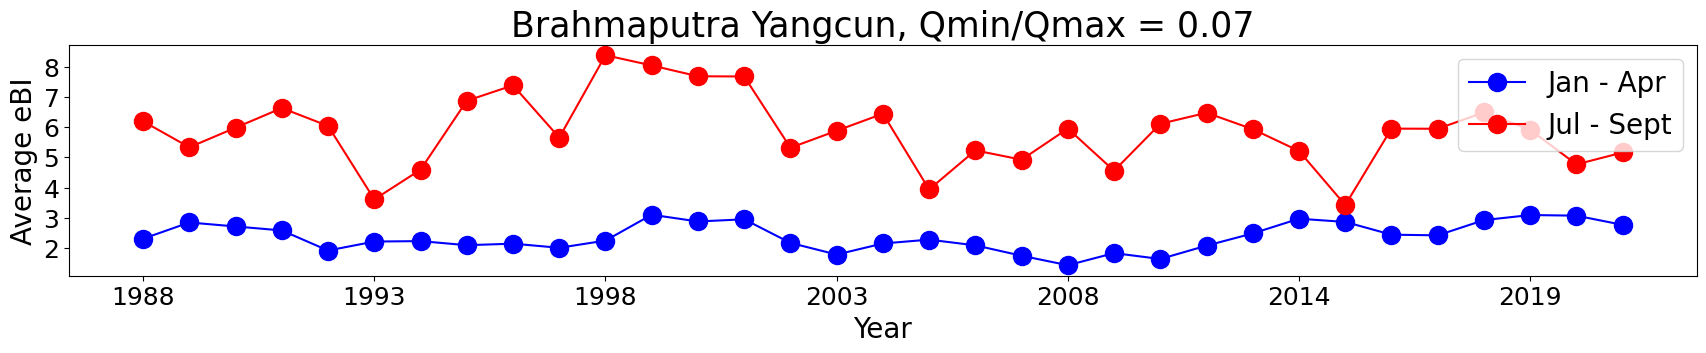

In [187]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\GEE_watermasks-master\ebi\Brahmaputra_Yangcun\rivgraph\eBI_results.csv"



df = pd.read_csv(csv_filepath, header=None)
# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '01' else 'Jul'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['07'], marker='o', color='red', linestyle='-', markersize=13)

plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Brahmaputra Yangcun, Qmin/Qmax = 0.07', fontsize=25)
plt.xticks(df_grouped.index[::5], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Apr', 'Jul - Sept'], loc='upper right', fontsize=20)
# Show the plot
plt.show()


In [9]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Solimoes_Tabatinga\rivgraph\eBI_results.csv"



df = pd.read_csv(csv_filepath, header=None)
# Calculate the average for each row excluding the 'year' column
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Create a new column for labeling based on the condition
df['label'] = df.apply(lambda row: f"{row['year']}\n{'Jan' if row['month'] == '01' else 'Jul'}", axis=1)

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['07'], marker='o', color='red', linestyle='-', markersize=13)

plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Brahmaputra Yangcun, Qmin/Qmax = 0.07', fontsize=25)
plt.xticks(df_grouped.index[::5], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Apr', 'Jul - Sept'], loc='upper right', fontsize=20)
# Show the plot
plt.show()

IndexError: list index out of range

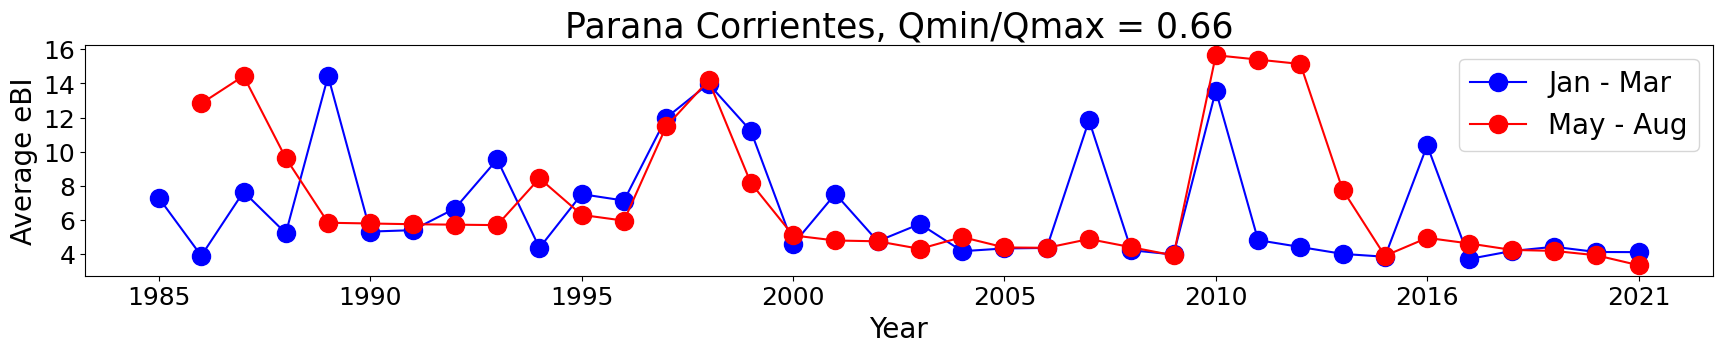

In [188]:
# Assuming csv_filepath is the path to your CSV file
csv_filepath = r"C:\Users\Feifei\GEE_watermasks-master\ebi\Parana_Corrientes\rivgraph\eBI_results.csv"


df = pd.read_csv(csv_filepath, header=None)
df['average_eBI'] = df[df.columns[df.columns != 0]].mean(axis=1, skipna=True)

# Extract the year and month from the first column (file names)
df['year'] = df[0].apply(lambda x: str(x).split('_')[1] if isinstance(x, str) else '')
df['month'] = df[0].apply(lambda x: str(x).split('_')[2][:2] if isinstance(x, str) else '')

# Group by year and calculate the average for January and non-January data
df_grouped = df.groupby(['year', 'month'])['average_eBI'].mean().unstack()

# Interpolate NaN values for each column (month)
df_grouped.interpolate(axis=0, inplace=True)

# Set the figure size before plotting
plt.figure(figsize=(21, 3))  # Adjust the values (width, height) as needed

# Plot January data in blue with lines connecting points
plt.plot(df_grouped.index, df_grouped['01'], marker='o', color='blue', linestyle='-', markersize=13)

# Plot non-January data in red with lines connecting points
plt.plot(df_grouped.index, df_grouped['05'], marker='o', color='red', linestyle='-', markersize=13)


plt.xlabel('Year', fontsize=20)
plt.ylabel('Average eBI', fontsize=20)
plt.title('Parana Corrientes, Qmin/Qmax = 0.66', fontsize=25)
plt.xticks(df_grouped.index[::5], fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Jan - Mar', 'May - Aug'],loc='upper right', fontsize=20)
# Show the plot
plt.show()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

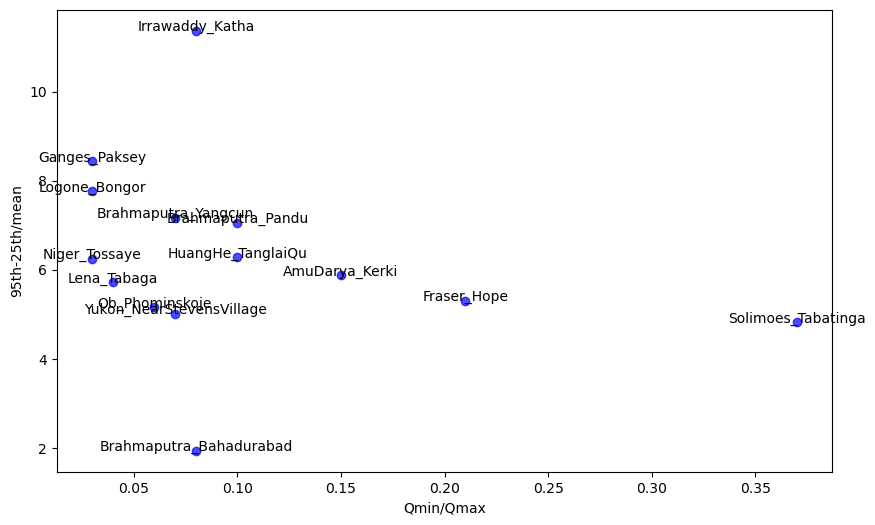

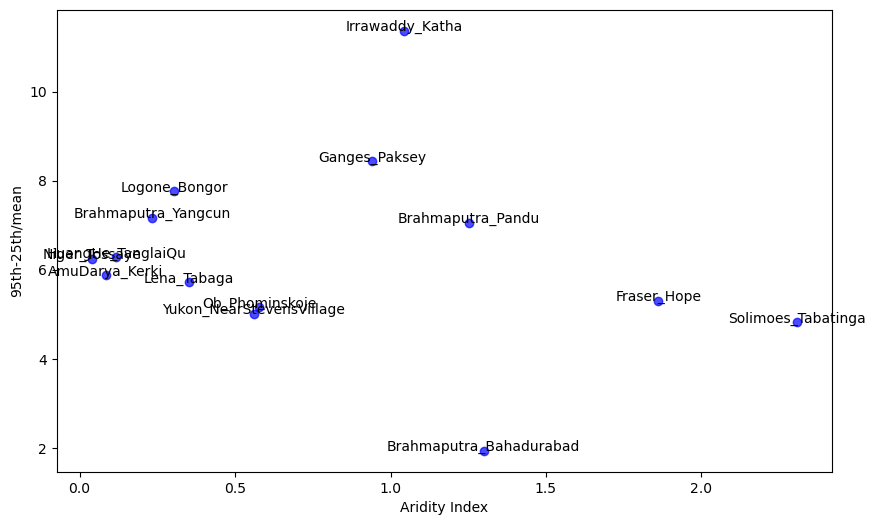

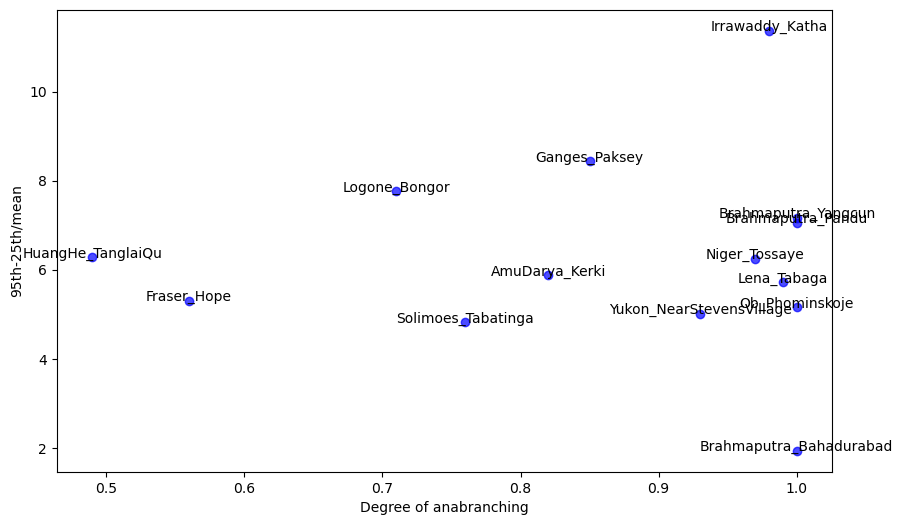

In [3]:

# Define the root directory
root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'

# Function to calculate the difference between 5th and 95th percentiles and normalize by mean
def calculate_percentile_difference(data):
    # Calculate percentiles
    percentile_5 = np.percentile(data, 5)
    percentile_95 = np.percentile(data, 95)
    percentile_difference = percentile_95 - percentile_5
    # Normalize by mean
    mean_value = np.mean(data)
    normalized_difference = percentile_difference / mean_value
    return normalized_difference

# Load the CSV file containing river names and aridity index values
river_aridity_file = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Galeazzi_multithread_AI.csv"  
river_aridity_df = pd.read_csv(river_aridity_file)

river_aridity_dict = {}
for index, row in river_aridity_df.iterrows():
    river_name = row['River_Station']
    aridity_index = row['aridity_index']
    qmin_qmax = row['Qmin_Qmax']
    anabranching = row['Deg_Anabranching']
    river_aridity_dict[river_name] = (aridity_index, qmin_qmax, anabranching)

# Lists to store data for plotting
aridity_indices = []
qmin_qmax_values = []
anabranching_values=[]
percentile_differences = []
river_names = []

# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        # Check if 'rivgraph' folder exists
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            # Find CSV file in 'rivgraph' folder
            for file in os.listdir(rivgraph_path):
                if file.endswith('.csv'):
                    csv_file_path = os.path.join(rivgraph_path, file)
                    # Open CSV file and calculate percentile difference
                    with open(csv_file_path, 'r') as f:
                        # Initialize list to store data
                        data = []
                        # Process each line
                        for line in f:
                            fields = line.strip().split(',')
                            # Skip the first column (assuming it's non-numeric)
                            for field in fields[1:]:
                                # Convert numeric fields to floats and append to data list
                                try:
                                    data.append(float(field))
                                except ValueError:
                                    pass  # Skip non-numeric fields
                        # Calculate percentile difference
                        percentile_difference = calculate_percentile_difference(data)
                        # Get the corresponding aridity index and Qmin_Qmax values
                        river_name = river_folder  # Use the river folder name directly
                        aridity_index, qmin_qmax, anabranching = river_aridity_dict.get(river_name, (np.nan, np.nan))
                        # Append data to lists
                        aridity_indices.append(aridity_index)
                        qmin_qmax_values.append(qmin_qmax)
                        anabranching_values.append(anabranching)
                        percentile_differences.append(percentile_difference)
                        river_names.append(river_folder)

# Plot Qmin/Qmax
plt.figure(figsize=(10, 6))
plt.scatter(qmin_qmax_values, percentile_differences, c='blue', alpha=0.7)
# Add labels and title
plt.xlabel('Qmin/Qmax')
plt.ylabel('95th-25th/mean')
# Add labels for each point
for i, txt in enumerate(river_names):
    plt.annotate(txt, (qmin_qmax_values[i], percentile_differences[i]), fontsize=10, ha='center')

plt.show()

# Plot aridity index 
plt.figure(figsize=(10, 6))
plt.scatter(aridity_indices, percentile_differences, c='blue', alpha=0.7)
# Add labels and title
plt.xlabel('Aridity Index')
plt.ylabel('95th-25th/mean')
# Add labels for each point
for i, txt in enumerate(river_names):
    plt.annotate(txt, (aridity_indices[i], percentile_differences[i]), fontsize=10, ha='center')

plt.show()

# Plot deg of anabranching
plt.figure(figsize=(10, 6))
plt.scatter(anabranching_values, percentile_differences, c='blue', alpha=0.7)
# Add labels and title
plt.xlabel('Degree of anabranching')
plt.ylabel('95th-25th/mean')
# Add labels for each point
for i, txt in enumerate(river_names):
    plt.annotate(txt, (anabranching_values[i], percentile_differences[i]), fontsize=10, ha='center')

plt.show()


Mean yearly eBI difference for eBI_results.csv: 0.28579875422433965
Mean yearly eBI difference for eBI_results.csv: 5.762349043950108
Mean yearly eBI difference for eBI_results.csv: 5.686340152314523
Mean yearly eBI difference for eBI_results.csv: 3.5243429492806357
Mean yearly eBI difference for eBI_results.csv: 0.5618208071460185
Mean yearly eBI difference for eBI_results.csv: 1.5524288137917894
Mean yearly eBI difference for eBI_results.csv: 0.45445961639317356
Mean yearly eBI difference for eBI_results.csv: 1.9506223555862956
Mean yearly eBI difference for eBI_results.csv: 1.0103062359692698
Mean yearly eBI difference for eBI_results.csv: 0.7790884091314229
Mean yearly eBI difference for eBI_results.csv: 0.47694973315211264
Mean yearly eBI difference for eBI_results.csv: 0.5015567995040433
Mean yearly eBI difference for eBI_results.csv: 0.3816291047959812
Mean yearly eBI difference for eBI_results.csv: 0.42126589888916977


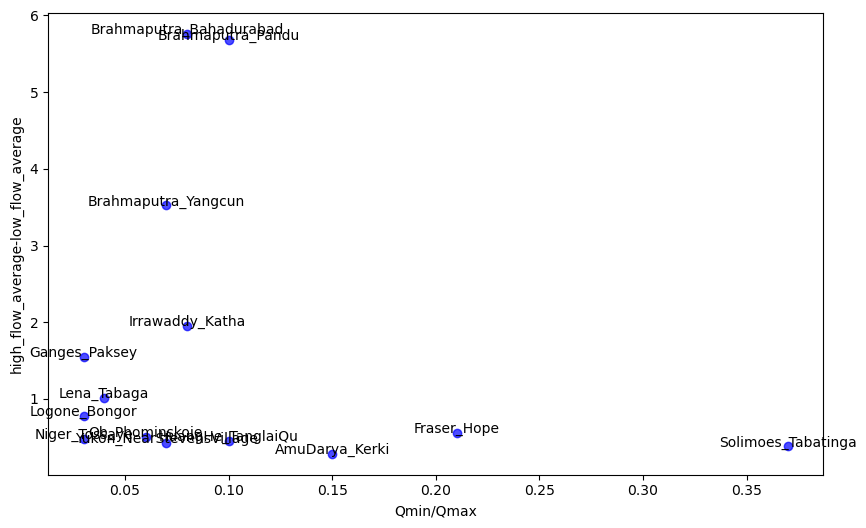

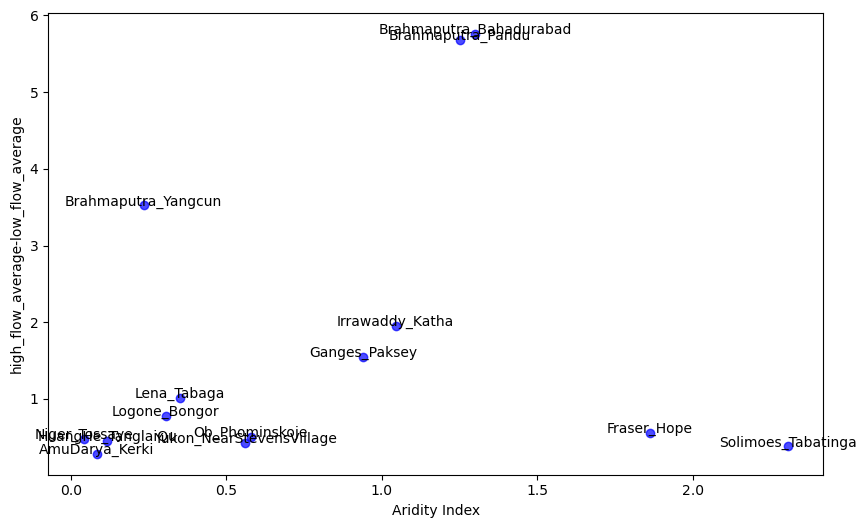

In [14]:


# Lists to store data for plotting
aridity_indices = []
qmin_qmax_values = []
anabranching_values = []
eBI_differences_list = []
river_names = []

root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'

# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            for file in os.listdir(rivgraph_path):
                if file.endswith('.csv'):
                    csv_file_path = os.path.join(rivgraph_path, file)
                    try:
                        df = pd.read_csv(csv_file_path)
                        if all(col in df.columns for col in ['Month_range', 'Year', 'eBI']):
                            grouped_eBI = df.groupby(['Year', 'Month_range'])['eBI'].mean().reset_index()
                            yearly_differences = []

                            years = grouped_eBI['Year'].unique()
                            for year in years:
                                year_data = grouped_eBI[grouped_eBI['Year'] == year]
                                if len(year_data['Month_range'].unique()) == 2:
                                    difference = abs(year_data['eBI'].iloc[0] - year_data['eBI'].iloc[1])
                                    yearly_differences.append(difference)

                            # Now, calculate the mean of all yearly differences for this river
                            if yearly_differences:  # Ensure the list is not empty
                                eBI_differences = np.median(yearly_differences)
                            else:
                                eBI_differences = np.nan  # Use NaN if there were no valid differences

                            print(f"Mean yearly eBI difference for {file}: {eBI_differences}")
                        else:
                            print(f"Required columns are missing in {file}.")

                    except Exception as e:
                        print(f"Error processing {file}: {e}")

                    river_name = river_folder
                    aridity_index, qmin_qmax, anabranching = river_aridity_dict.get(river_name, (np.nan, np.nan, np.nan))
                    aridity_indices.append(aridity_index)
                    qmin_qmax_values.append(qmin_qmax)
                    anabranching_values.append(anabranching)
                    eBI_differences_list.append(eBI_differences)
                    river_names.append(river_folder)

# Proceed with the plotting as before


# Plot Qmin/Qmax
plt.figure(figsize=(10, 6))
plt.scatter(qmin_qmax_values, eBI_differences_list, c='blue', alpha=0.7)
# Add labels and title
plt.xlabel('Qmin/Qmax')
plt.ylabel('high_flow_average-low_flow_average')
# Add labels for each point
for i, txt in enumerate(river_names):
    plt.annotate(txt, (qmin_qmax_values[i], eBI_differences_list[i]), fontsize=10, ha='center')

plt.show()

# Plot aridity index 
plt.figure(figsize=(10, 6))
plt.scatter(aridity_indices, eBI_differences_list, c='blue', alpha=0.7)
# Add labels and title
plt.xlabel('Aridity Index')
plt.ylabel('high_flow_average-low_flow_average')
# Add labels for each point
for i, txt in enumerate(river_names):
    plt.annotate(txt, (aridity_indices[i], eBI_differences_list[i]), fontsize=10, ha='center')

plt.show()


Mean yearly eBI difference for eBI_results.csv: 0.28579875422433965
Mean yearly eBI difference for eBI_results.csv: 5.762349043950108
Mean yearly eBI difference for eBI_results.csv: 5.686340152314523
Mean yearly eBI difference for eBI_results.csv: 3.5243429492806357
Mean yearly eBI difference for eBI_results.csv: 0.5618208071460185
Mean yearly eBI difference for eBI_results.csv: 1.5524288137917894
Mean yearly eBI difference for eBI_results.csv: 0.45445961639317356
Mean yearly eBI difference for eBI_results.csv: 1.9506223555862956
Mean yearly eBI difference for eBI_results.csv: 1.0103062359692698
Mean yearly eBI difference for eBI_results.csv: 0.7790884091314229
Mean yearly eBI difference for eBI_results.csv: 0.47694973315211264
Mean yearly eBI difference for eBI_results.csv: 0.5015567995040433
Mean yearly eBI difference for eBI_results.csv: 0.3816291047959812
Mean yearly eBI difference for eBI_results.csv: 0.42126589888916977


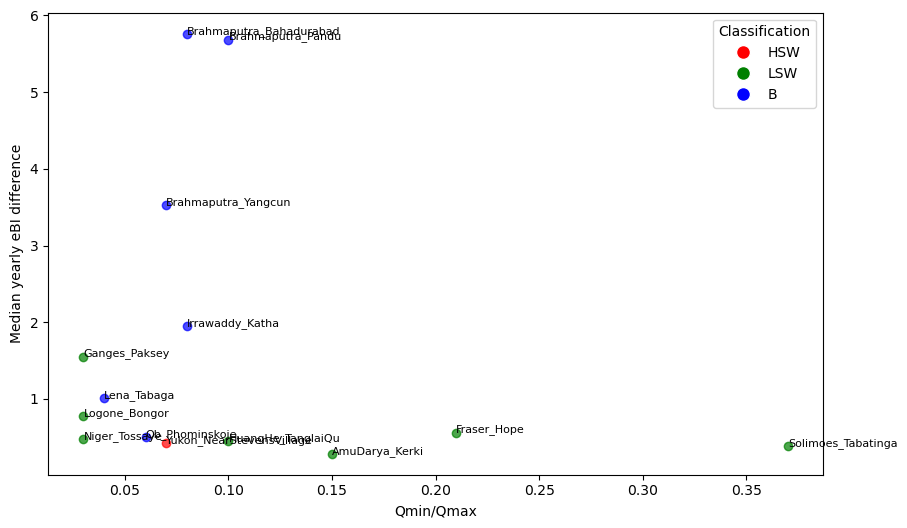

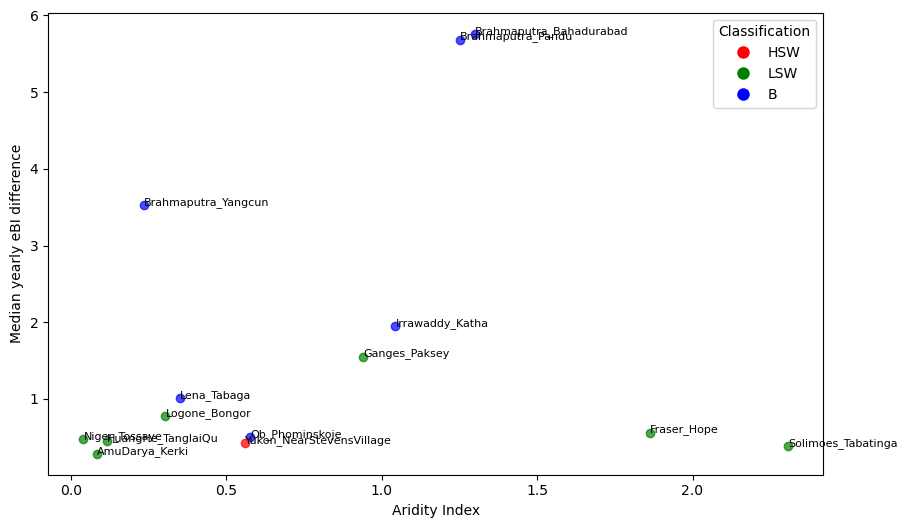

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the CSV file containing river names, aridity index values, and classifications
river_aridity_file = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Galeazzi_multithread_AI.csv"
river_aridity_df = pd.read_csv(river_aridity_file)

river_aridity_dict = {}
for index, row in river_aridity_df.iterrows():
    river_name = row['River_Station']
    aridity_index = row['aridity_index']
    qmin_qmax = row['Qmin_Qmax']
    anabranching = row['Deg_Anabranching']
    classification = row['Classification']  # New: Read Classification column
    river_aridity_dict[river_name] = (aridity_index, qmin_qmax, anabranching, classification)

# Lists to store data for plotting
aridity_indices = []
qmin_qmax_values = []
anabranching_values = []
eBI_differences_list = []
river_names = []
classifications = []  # New: Store classifications for coloring

root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'

# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            for file in os.listdir(rivgraph_path):
                if file.endswith('.csv'):
                    csv_file_path = os.path.join(rivgraph_path, file)
                    try:
                        df = pd.read_csv(csv_file_path)
                        if all(col in df.columns for col in ['Month_range', 'Year', 'eBI']):
                            grouped_eBI = df.groupby(['Year', 'Month_range'])['eBI'].mean().reset_index()
                            yearly_differences = []

                            years = grouped_eBI['Year'].unique()
                            for year in years:
                                year_data = grouped_eBI[grouped_eBI['Year'] == year]
                                if len(year_data['Month_range'].unique()) == 2:
                                    difference = abs(year_data['eBI'].iloc[0] - year_data['eBI'].iloc[1])
                                    yearly_differences.append(difference)

                            # Now, calculate the mean of all yearly differences for this river
                            if yearly_differences:  # Ensure the list is not empty
                                eBI_differences = np.median(yearly_differences)
                            else:
                                eBI_differences = np.nan  # Use NaN if there were no valid differences

                            print(f"Mean yearly eBI difference for {file}: {eBI_differences}")
                        else:
                            print(f"Required columns are missing in {file}.")

                    except Exception as e:
                        print(f"Error processing {file}: {e}")

                    river_name = river_folder
                    aridity_index, qmin_qmax, anabranching, classification = river_aridity_dict.get(river_name, (np.nan, np.nan, np.nan, np.nan))
                    aridity_indices.append(aridity_index)
                    qmin_qmax_values.append(qmin_qmax)
                    anabranching_values.append(anabranching)
                    eBI_differences_list.append(eBI_differences)
                    river_names.append(river_folder)
                    classifications.append(classification)  # New: Store classification

# Define color mapping for classifications
color_mapping = {'HSW': 'red', 'LSW': 'green', 'B': 'blue'}

# Create scatter plot colored by classification for Qmin/Qmax
plt.figure(figsize=(10, 6))
for classification, x, y, name in zip(classifications, qmin_qmax_values, eBI_differences_list, river_names):
    plt.scatter(x, y, c=color_mapping.get(classification, 'black'), alpha=0.7)
    plt.text(x, y, name, fontsize=8)  # Add river name as text label

# Add labels and title
plt.xlabel('Qmin/Qmax')
plt.ylabel('Median yearly eBI difference')

# Add legend for classifications
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key,
                               markerfacecolor=color_mapping[key], markersize=10) for key in color_mapping.keys()]
plt.legend(handles=legend_elements, title='Classification')

plt.show()

# Create scatter plot colored by classification for aridity index
plt.figure(figsize=(10, 6))
for classification, x, y, name in zip(classifications, aridity_indices, eBI_differences_list, river_names):
    plt.scatter(x, y, c=color_mapping.get(classification, 'black'), alpha=0.7)
    plt.text(x, y, name, fontsize=8)  # Add river name as text label

# Add labels and title
plt.xlabel('Aridity Index')
plt.ylabel('Median yearly eBI difference')

# Add legend for classifications
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key,
                               markerfacecolor=color_mapping[key], markersize=10) for key in color_mapping.keys()]
plt.legend(handles=legend_elements, title='Classification')

plt.show()


Difference for eBI_results.csv: 0.08315267507693225
Difference for eBI_results.csv: 5.926837447500825
Difference for eBI_results.csv: 7.140746064926627
Difference for eBI_results.csv: 3.485303347087609
Difference for eBI_results.csv: 0.5717047461192393
Difference for eBI_results.csv: 1.8173612219693784
Difference for eBI_results.csv: 0.24110977224456764
Difference for eBI_results.csv: 2.0117786972730727
Difference for eBI_results.csv: 0.7079658508739364
Difference for eBI_results.csv: 0.7573005912527646
Difference for eBI_results.csv: 0.8082995798509374
Difference for eBI_results.csv: 0.5863633333159939
Required columns are missing in BI_results.csv.
Difference for eBI_results.csv: 0.4489983037015124
Difference for eBI_results.csv: 0.26773493677265625
Required columns are missing in BI_results.csv.
Difference for eBI_results.csv: 0.7352978707045374
Difference for eBI_results.csv: 0.3742212845240509


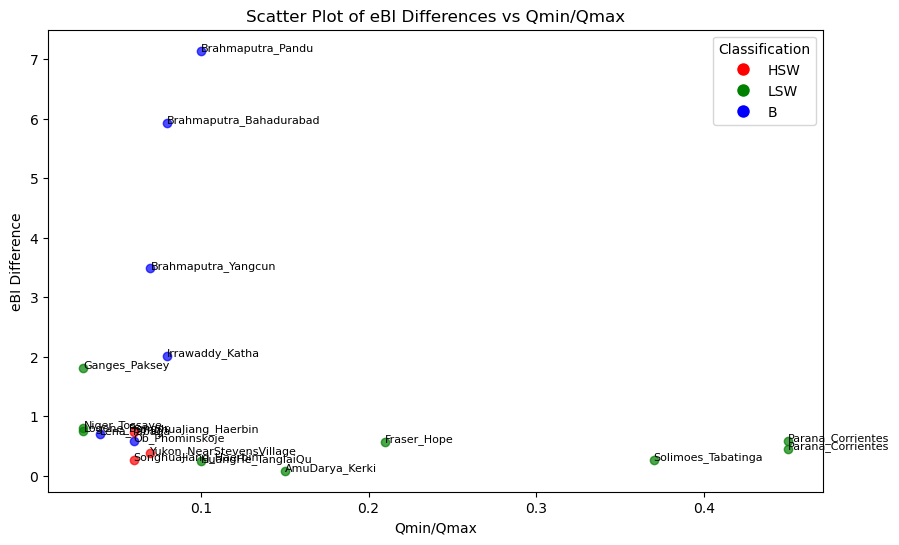

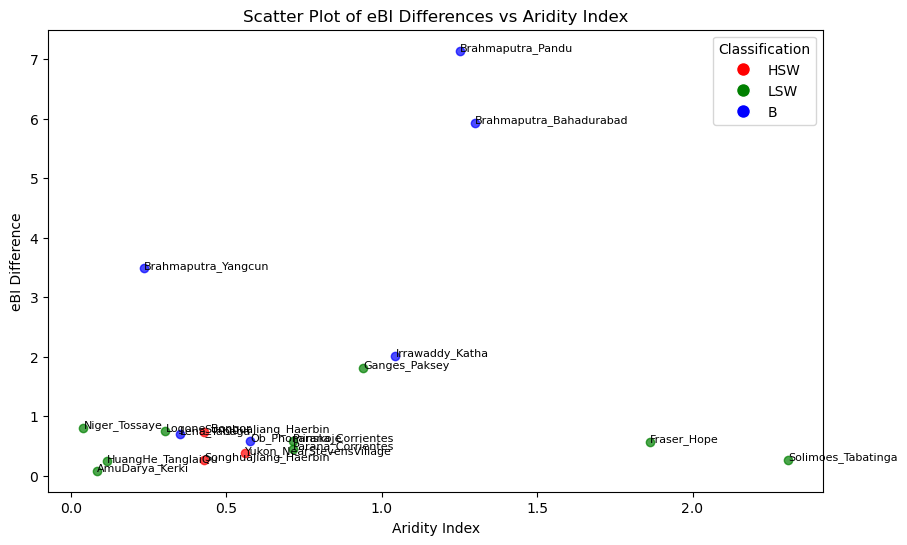

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the CSV file containing river names, aridity index values, and classifications
river_aridity_file = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Galeazzi_multithread_AI.csv"
river_aridity_df = pd.read_csv(river_aridity_file)

river_aridity_dict = {}
for index, row in river_aridity_df.iterrows():
    river_name = row['River_Station']
    aridity_index = row['aridity_index']
    qmin_qmax = row['Qmin_Qmax']
    anabranching = row['Deg_Anabranching']
    classification = row['Classification']  # New: Read Classification column
    river_aridity_dict[river_name] = (aridity_index, qmin_qmax, anabranching, classification)

# Lists to store data for plotting
aridity_indices = []
qmin_qmax_values = []
anabranching_values = []
eBI_differences_list = []
river_names = []
classifications = []  # New: Store classifications for coloring

root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'

# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            for file in os.listdir(rivgraph_path):
                if file.endswith('.csv'):
                    csv_file_path = os.path.join(rivgraph_path, file)
                    try:
                        df = pd.read_csv(csv_file_path)
                        if all(col in df.columns for col in ['Month_range', 'eBI']):
                            # Group eBI values by Month_range
                            grouped_eBI = df.groupby('Month_range')['eBI'].mean().reset_index()
                            if len(grouped_eBI) == 2:  # Ensure there are only two unique Month_ranges
                                difference = abs(grouped_eBI['eBI'].iloc[0] - grouped_eBI['eBI'].iloc[1])
                            else:
                                difference = np.nan  # Set to NaN if there are not exactly two unique Month_ranges
                            
                            print(f"Difference for {file}: {difference}")
                        else:
                            print(f"Required columns are missing in {file}.")

                    except Exception as e:
                        print(f"Error processing {file}: {e}")

                    river_name = river_folder
                    aridity_index, qmin_qmax, anabranching, classification = river_aridity_dict.get(river_name, (np.nan, np.nan, np.nan, np.nan))
                    aridity_indices.append(aridity_index)
                    qmin_qmax_values.append(qmin_qmax)
                    anabranching_values.append(anabranching)
                    eBI_differences_list.append(difference)
                    river_names.append(river_folder)
                    classifications.append(classification)  # New: Store classification

# Define color mapping for classifications
color_mapping = {'HSW': 'red', 'LSW': 'green', 'B': 'blue'}

# Create scatter plot colored by classification for Qmin/Qmax
plt.figure(figsize=(10, 6))
for classification, x, y, name in zip(classifications, qmin_qmax_values, eBI_differences_list, river_names):
    plt.scatter(x, y, c=color_mapping.get(classification, 'black'), alpha=0.7)
    plt.text(x, y, name, fontsize=8)  # Add river name as text label

# Add labels and title
plt.xlabel('Qmin/Qmax')
plt.ylabel('eBI Difference')
plt.title('Scatter Plot of eBI Differences vs Qmin/Qmax')

# Add legend for classifications
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key,
                               markerfacecolor=color_mapping[key], markersize=10) for key in color_mapping.keys()]
plt.legend(handles=legend_elements, title='Classification')

plt.show()

# Create scatter plot colored by classification for aridity index
plt.figure(figsize=(10, 6))
for classification, x, y, name in zip(classifications, aridity_indices, eBI_differences_list, river_names):
    plt.scatter(x, y, c=color_mapping.get(classification, 'black'), alpha=0.7)
    plt.text(x, y, name, fontsize=8)  # Add river name as text label

# Add labels and title
plt.xlabel('Aridity Index')
plt.ylabel('eBI Difference')
plt.title('Scatter Plot of eBI Differences vs Aridity Index')

# Add legend for classifications
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key,
                               markerfacecolor=color_mapping[key], markersize=10) for key in color_mapping.keys()]
plt.legend(handles=legend_elements, title='Classification')

plt.show()


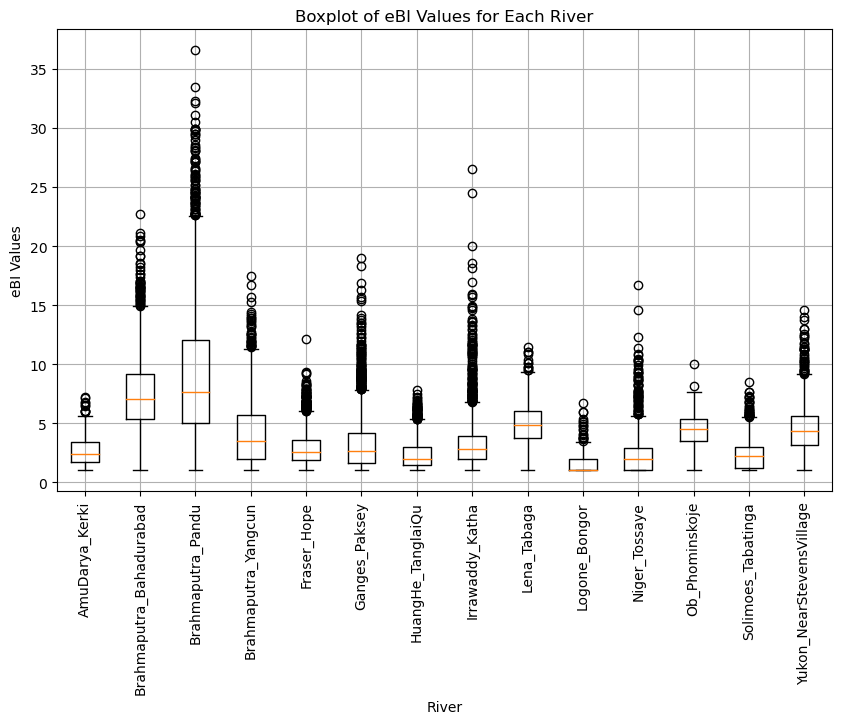

In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt

root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'

# Create a list to store eBI values for each river
eBI_data = []

# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            for file in os.listdir(rivgraph_path):
                if file.endswith('.csv'):
                    csv_file_path = os.path.join(rivgraph_path, file)
                    try:
                        df = pd.read_csv(csv_file_path)
                        if 'eBI' in df.columns:
                            eBI_values = df['eBI'].dropna().tolist()  # Add non-null eBI values to the list
                            eBI_data.append((river_folder, eBI_values))
                        else:
                            print(f"eBI column not found in {file}. Skipping...")
                    except Exception as e:
                        print(f"Error processing {file}: {e}")

# Create a list of eBI values and a list of corresponding river names
eBI_values = [data[1] for data in eBI_data]
river_names = [data[0] for data in eBI_data]

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(eBI_values, labels=river_names)
plt.xticks(rotation=90)
plt.xlabel('River')
plt.ylabel('eBI Values')
plt.title('Boxplot of eBI Values for Each River')
plt.grid(True)
plt.show()


